# Notebook for reading simulation outputs

**In this notebook, you will:**
- 1. read raw parflow binary files (*.pfb)
- 2. read a bunch of output files and auxiliary variables
- 3. process output data to get advanced variables (water table depth, runoff...)

**Material**: 

**ParFlow**
- Parflow manual, including python's pftools: ReadTheDocs: https://parflow.readthedocs.io/en/latest/
- Parflow front site: https://parflow.org/
- Parflow git: https://github.com/parflow/parflow
- Parflow blog: http://parflow.blogspot.com/
- Parflow installation: https://github.com/parflow/parflow/wiki/Ubuntu-20.04.1-LTS---Factory-condition

**Python**
- Python tuto: https://docs.python.org/3/tutorial/
- Cheat sheet python for data science: https://datacamp-community-prod.s3.amazonaws.com/e30fbcd9-f595-4a9f-803d-05ca5bf84612
- Cheat sheet Pandas: http://datacamp-community-prod.s3.amazonaws.com/dbed353d-2757-4617-8206-8767ab379ab3
- Cheat Sheet Pandas #2 : https://gricad-gitlab.univ-grenoble-alpes.fr/voisind/m1-variabilite/-/blob/master/aide/Enthought-Python-Pandas-Cheat-Sheets-1-8-v1.0.2.pdf
- Xarray: https://docs.xarray.dev/en/stable/index.html

**References:**
- **ParFlow development**: summary in : Kuffour, B.N.O., Engdahl, N.B., Woodward, C.S., Condon, L.E., Kollet, S., and Maxwell, R.M. (2020). Simulating coupled surface-subsurface flows with ParFlow v3.5.0: capabilities, applications, and ongoing development of an open-source, massively parallel, integrated hydrologic model. Geosci. Model Dev., 13(3), 1373-1397, doi:10.5194/gmd-13-1373-2020. https://gmd.copernicus.org/articles/13/1373/2020/

- **ParFlow**: 
    - Kollet, S. J. and Maxwell, R. M.: Integrated surface-groundwater flow modeling: A free-surface overland flow boundary condition in a parallel groundwater flow model, Adv. Water Resour., 29, 945–958, https://doi.org/10.1016/j.advwatres.2005.08.006, 2006.
    - Maxwell, R. M.: A terrain-following grid transform and preconditioner for parallel, large-scale, integrated hydrologic modeling, Adv. Water Resour., 53, 109–117, https://doi.org/10.1016/j.advwatres.2012.10.001, 2013. 
    - Maxwell, R. M., Condon, L. E., and Kollet, S. J.: A high-resolution simulation of groundwater and surface water over most of the continental US with the integrated hydrologic model ParFlow v3, Geosci. Model Dev., 8, 923–937, https://doi.org/10.5194/gmd-8-923-2015, 2015. 
    - Maxwell, R.M. and Condon, L.E. (2016). Connections between groundwater flow and transpiration partitioning. Science, 353(6297), 377-380. doi:10.1126/science.aaf7891.
    
- **CLM**: 
    - Dai, Y., Zeng, X., Dickinson, R. E., Baker, I., Bonan, G. B., Bosilovich, M. G., Denning, A. S., Dirmeyer, P. A., Houser, P. R., Niu, G., and Oleson, K. W.: The Common Land Model, B. Am. Meteorol. Soc., 84, 1013–1023, https://doi.org/10.1175/BAMS-84-8-1013, 2003. 
    - Maxwell, R. M. and Miller, N. L.: Development of a Coupled Land Surface and Groundwater Model, J. Hydrometeorol., 6, 233–247, https://doi.org/10.1175/JHM422.1, 2005. 
    - Jefferson, J. L. and Maxwell, R. M.: Evaluation of simple to complex parameterizations of bare ground evaporation, J. Adv. Model. Earth Syst., 7, 1075–1092, https://doi.org/10.1002/2014MS000398, 2015. 
    - Jefferson, J. L., Maxwell,R. M., and Constantine, P. G.: Exploring the Sensitivity of Photosynthesis and Stomatal Resistance Parameters in a Land Surface Model, J. Hydrometeorol., 18, 897–915, https://doi.org/10.1175/JHM-D-16-0053.1, 2017. 
    
## Summary
* [1. Reading parflow binary outputs](#t1)
    * [1.0. Define simulation location](#t1_0)
    * [1.1. Using a simple function](#t1_1)
    * [1.2.  Using pftools](#t1_2)
        * [1.2.1  Using the standard read_pfb](#t1_2_1)
        * [1.2.2  Using the read_pfb_sequence to read several time steps](#t1_2_2)
    * [1.3. Using the xarray  accessor](#t1_3)
* [2. Read a bunch of output files](#t2)
    * [2.1. Read ParFlow output files](#t2_1)
    * [2.2. Read CLM output files](#t2_2)
* [3. Process output files](#t3)
    * [3.1. Water Table Depth](#t3_1)
    * [3.2. Runoff](#t3_2)
        * [3.2.1. Computed from the surface pressure (from CLM)](#t3_2_1)
        * [3.2.2. Read from the cumulative overlandsum file (from PF)](#t3_2_2)
    * [3.3. Storage](#t3_3)
      
    

In [108]:
import numpy as np
import os,glob,struct
import xarray as xr
import pandas as pd
import datetime as dt

## 1. Reading parflow binary outputs (.pfb) <a class="anchor" id="t1"></a>
native parflow format is .pfb, these are binary files with a header giving the parflow grid information and a matrix (1D,2D, or 3D). 
Here, we aim at building a dataArray object using xarray module to eventually save or work with .netcdf, a common and standard exchange format for such kind of gridded data

### 1.0. Define simulation location  <a class="anchor" id="t1_0"></a>

In [109]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/simus/"
wdir = root_dir+'results_benchmark/'
hill = Run.from_definition(root_dir+'hillslope.pfidb')

 => Error during CLM import - CLM specific key have been skipped


### 1.1. Using a simple function <a class="anchor" id="t1_1"></a>
reading .pfb is actually pretty simple, let's write a simple function

In [3]:
def PFB_read(pfb_file_path, flag):

    #print("**This code DOES handle subgrids**")
    # flag = 1: return array + header
    # flag = 0: return array only
    
    hdr_dict = {}
    
    with open(pfb_file_path,'rb') as pfbf:
        hdr_dict['X0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Y0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['Z0'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['nx'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['ny'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['nz'] = struct.unpack('>i', pfbf.read(4))[0]
        hdr_dict['dx'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dy'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['dz'] = struct.unpack('>d', pfbf.read(8))[0]
        hdr_dict['ns'] = struct.unpack('>i', pfbf.read(4))[0]
        ns = hdr_dict['ns']
        #print(ns)
        nx = hdr_dict['nx']
        ny = hdr_dict['ny']
        nz = hdr_dict['nz']
        
        if nx == 0:
            nx = int(raw_input("What should the NX be?"))
            hdr_dict['nx'] = nx
        if ny == 0:
            ny = int(raw_input("What should the NY be?"))
            hdr_dict['ny'] = ny
        if nz ==0:
            nz =int(raw_input("What should the NZ be?"))
            hdr_dict['nz'] = nz
        
        X0 = hdr_dict['X0']
        #print "len_x, len_y, len_z, nx ny nz --> %f %f %f %i %i %i" %(len_x, len_x, len_x, nx, ny, nz)
        
        pfb_array = np.zeros((nx, ny, nz))
        
        for subgrids in range(ns):
            hdr_dict['ix'] = struct.unpack('>i', pfbf.read(4))[0]
            ix = hdr_dict['ix']
            hdr_dict['iy'] = struct.unpack('>i', pfbf.read(4))[0]
            iy = hdr_dict['iy']
            #print(iy)
            hdr_dict['iz'] = struct.unpack('>i', pfbf.read(4))[0]
            iz = hdr_dict['iz']
            hdr_dict['nx2'] = struct.unpack('>i', pfbf.read(4))[0]
            nx2 = hdr_dict['nx2']
            hdr_dict['ny2'] = struct.unpack('>i', pfbf.read(4))[0]
            ny2 = hdr_dict['ny2']
            #print(ny2)
            hdr_dict['nz2'] = struct.unpack('>i', pfbf.read(4))[0]
            nz2 = hdr_dict['nz2']
            hdr_dict['rx'] = struct.unpack('>i', pfbf.read(4))[0]
            rx = hdr_dict['rx']
            hdr_dict['ry'] = struct.unpack('>i', pfbf.read(4))[0]
            ry = hdr_dict['ry']
            hdr_dict['rz'] = struct.unpack('>i', pfbf.read(4))[0]
            rz = hdr_dict['rz']
            #print "ix iy iz nx2 ny2 nz2 rx ry rz --> %i %i %i %i %i %i %i %i %i\n" %(ix,iy, iz, nx2, ny2, nz2, rx,ry, rz)
            for lays in range(nz2):
                for rows in range(ny2):
                    for cols in range(nx2):
                        val = struct.unpack('>d', pfbf.read(8))[0]
                        #q = raw_input(val)
                        pfb_array[(cols+ix), (rows + iy), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(cols+ix-1), (nx2-(iy)-1), (nz2-(lays + iz)-1)] = val
                        #pfb_array[(rows + iy-1), (cols+ix-1), (nz2-(lays + iz)-1)] = val
                        #print val
                        
    if flag ==1:
        return(pfb_array, hdr_dict)
    else:
        return(pfb_array)


Then, we can simply identify all files...

In [4]:
"""identify files"""
files = glob.glob(os.path.join(wdir,'*press.*.pfb'))
files.sort()
#skip initial condition
files.pop(0)

'/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/simus/results_benchmark/hillslope.out.press.00000.pfb'

... read the header of a single file...

In [5]:
"""reads in the first file to have the dimension & initialize"""
d,h=PFB_read(files[0],1)
print(h)

{'X0': 0.0, 'Y0': 0.0, 'Z0': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'ns': 2, 'ix': 0, 'iy': 25, 'iz': 0, 'nx2': 1, 'ny2': 25, 'nz2': 24, 'rx': 0, 'ry': 0, 'rz': 0}


Then loop over files and read them all to fill a matrix

In [6]:
pressure_array = np.zeros([h['ny'],h['nz'],len(files)])
"""reads in all files"""
for t,f in enumerate(files):
    d,h=PFB_read(f,1)
    pressure_array[:,:,t] = d[0,:,:]

From these two information (the PF grid from the header, and the y,z matrix), only the time info is needed to build a dataArray

In [7]:
ds = xr.Dataset({"press": (("time","z","y"), np.swapaxes(pressure_array,2,0))},
    coords={"y":np.arange(start = h['Y0'],stop = h['Y0']+h['ny']*h['dy'],step=h['dy']),
        "z":np.arange(start = h['Z0'],stop = h['Z0']+h['nz']*h['dz'],step=h['dz']), 
        "time": pd.date_range("2005-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2005-01-01")})

ds.press.attrs['units']='m'
ds.y.attrs['units']='meters'
ds.z.attrs['units']='meters'

### 1.2. Using pftools <a class="anchor" id="t1_2"></a>

In [8]:
from parflow import read_pfb, read_pfb_sequence, ParflowBinaryReader


Access the header: 

In [9]:
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
print(h)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


#### 1.2.1. Using the standard read_pfb <a class="anchor" id="t1_2_1"></a>
This is pretty much the same as the hard coded function above

The example below reads in the dz multiplier file and help build the z vector

In [10]:
var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])[:,0,0]
var_dz = var_dz[::-1]
print('dz multiplier: ')
print(var_dz)
dz = var_dz * h['dz']
print('dz (m): ')
print(dz)
z = np.cumsum(dz) - var_dz/2 
print('z (m): ')
print(z)

dz multiplier: 
[0.01  0.01  0.01  0.01  0.092 0.092 0.092 0.092 0.092 0.16  0.16  0.16
 0.16  0.16  0.24  0.24  0.24  0.24  0.24  4.3   4.3   4.3   4.3   4.3  ]
dz (m): 
[0.01  0.01  0.01  0.01  0.092 0.092 0.092 0.092 0.092 0.16  0.16  0.16
 0.16  0.16  0.24  0.24  0.24  0.24  0.24  4.3   4.3   4.3   4.3   4.3  ]
z (m): 
[5.000e-03 1.500e-02 2.500e-02 3.500e-02 8.600e-02 1.780e-01 2.700e-01
 3.620e-01 4.540e-01 5.800e-01 7.400e-01 9.000e-01 1.060e+00 1.220e+00
 1.420e+00 1.660e+00 1.900e+00 2.140e+00 2.380e+00 4.650e+00 8.950e+00
 1.325e+01 1.755e+01 2.185e+01]


Then the same as in 1.1 can be applied (looping over file and read each one)

#### 1.2.2. Using the read_pfb_sequence to read several time steps: <a class="anchor" id="t1_2_2"></a>

List all files then reads them sequentially and store in an array

In [11]:
files = np.sort(glob.glob(wdir+'*.press.*.pfb'))
da = read_pfb_sequence(files)
np.shape(da)

(731, 24, 50, 1)

Then the xarray Dataset can be constructed directly

In [12]:
press = xr.Dataset({"press": (("time","z","y"), da[:,:,:,0])},
    coords={"y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
        "z":-z, 
        "time": pd.date_range("2005-01-01", periods=len(files)),
        "reference_time": pd.Timestamp("2005-01-01")})

ds.press.attrs['units']='m'
ds.y.attrs['units']='meters'
ds.z.attrs['units']='meters'

### 1.3 Using the xarray  accessor: <a class="anchor" id="t1_3"></a>

To read a single file: 

In [13]:
dslopex = xr.open_dataset(glob.glob(wdir+'*.out.slope_x.pfb')[0],name="slopex",engine='parflow')

In [14]:
dslopex

<xarray.Dataset>
Dimensions:  (y: 50)
Dimensions without coordinates: y
Data variables:
    slopex   (y) float64 ...

To read a sequence (**not yet ready**): 

In [15]:
ds = xr.open_dataset(wdir+'hillslope.out.pfmetadata',name="press",engine='parflow')

FileNotFoundError: [Errno 2] No such file or directory: '/home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/simus/results_benchmark//home/hectorb/PARFLOW/PROJECTS/test_cases/hillslope/ara_bele/simus/results_benchmark/hillslope.out.dzmult.pfb'

## 2. Read a bunch of output files <a class="anchor" id="t2"></a>

### 2.1. Read ParFlow output files <a class="anchor" id="t2_1"></a>

In [61]:
def read_pf_outputs(wdir,date_start="2005-01-01"):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get evaptranssum
    files = np.sort(glob.glob(wdir+'*.evaptranssum.*.pfb'))
    evaptranssum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "evaptranssum": (("time","z","y"), evaptranssum[:,::-1,:,0]),
                    'vdz': (("z","y","x"),var_dz[::-1,:,:])},
        coords={"y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files)),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.evaptranssum.attrs['units']='m3/hr'
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [62]:
ds1 = read_pf_outputs(root_dir+'results_benchmark/')

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


In [18]:
ds1

<xarray.Dataset>
Dimensions:         (time: 730, z: 24, y: 50)
Coordinates:
  * y               (y) float64 0.0 10.0 20.0 30.0 ... 460.0 470.0 480.0 490.0
  * z               (z) float64 -0.005 -0.015 -0.025 ... -13.25 -17.55 -21.85
  * time            (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2006-12-31
    reference_time  datetime64[ns] 2005-01-01
Data variables:
    press           (time, z, y) float64 -10.14 -10.14 -10.14 ... 8.883 8.382
    satur           (time, z, y) float64 0.1564 0.1564 0.1564 ... 0.9 0.9 0.9
    evaptranssum    (time, z, y) float64 -0.4115 -0.4115 -0.4115 ... 0.0 0.0 0.0
    WTD             (time, y) float64 9.629 9.858 9.949 ... 12.48 12.97 13.47

### 2.2. Read CLM output files  <a class="anchor" id="t2_2"></a>

following the PF.CLM manual, the CLM variables are: 

- *eflx_lh_tot* for latent heat flux total [W/m 2 ] 
- *eflx_lwrad_out* for outgoing long-wave radiation [W/m 2 ] 
- *eflx_sh_tot* for sensible heat flux total [W/m 2 ] 
- *eflx_soil_grnd* for ground heat flux [W/m 2 ] 
- *qflx_evap_tot* for total evaporation [mm/s] 
- *qflx_evap_grnd* for ground evaporation without condensation [mm/s] 
- *qflx_evap_soi* for soil evaporation [mm/s] 
- *qflx_evap_veg* for vegetation evaporation [mm/s] 
- *qflx_tran_veg* for vegetation transpiration [mm/s]
- *qflx_infl* for soil infiltration [mm/s]
- *swe_out* for snow water equivalent [mm]
- *t_grnd* for ground surface temperature [K]
- *t_soil* for soil temperature over all layers [K] 

In [19]:
def read_clm_outputs(wdir,date_start="2005-01-01"):
    files = np.sort(glob.glob(wdir+'*.clm_output.*.pfb'))
    clms = read_pfb_sequence(files)
    # create dataset
    ds = xr.Dataset({"lh_tot": (("time","y"), clms[:,0,:,0]),
                    "lwrad_out": (("time","y"), clms[:,1,:,0]),
                    "sh_tot": (("time","y"), clms[:,2,:,0]),
                    "soil_grnd": (("time","y"), clms[:,3,:,0]),
                    "evap_tot": (("time","y"), clms[:,4,:,0]*60*60),
                    "evap_grnd": (("time","y"), clms[:,5,:,0]*60*60),
                    "evap_soi": (("time","y"), clms[:,6,:,0]*60*60),
                    "evap_veg": (("time","y"), clms[:,7,:,0]*60*60),
                    "tran_veg": (("time","y"), clms[:,8,:,0]*60*60),
                    "infl": (("time","y"), clms[:,9,:,0]*60*60),
                    "swe_out": (("time","y"), clms[:,10,:,0]),
                    "t_grnd": (("time","y"), clms[:,11,:,0]),
                    "htop": (("time","y"), clms[:,12,:,0])},

        coords={"y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "time": pd.date_range(date_start, periods=len(files),freq='1H'),
            "reference_time": pd.Timestamp(date_start)})

    ds.lh_tot.attrs['units']='$W/m^2$'
    ds.lwrad_out.attrs['units']='$W/m^2$'
    ds.sh_tot.attrs['units']='$W/m^2$'
    ds.soil_grnd.attrs['units']='$W/m^2$'
    ds.evap_tot.attrs['units']='mm/h'
    ds.evap_grnd.attrs['units']='mm/h'
    ds.evap_soi.attrs['units']='mm/h'
    ds.evap_veg.attrs['units']='mm/h'
    ds.tran_veg.attrs['units']='mm/h'
    ds.infl.attrs['units']='mm/h'
    ds.swe_out.attrs['units']='mm'
    ds.t_grnd.attrs['units']='K'
    ds.htop.attrs['units']='m'

    ds.y.attrs['units']='meters'
    return ds

In [20]:
dc1 = read_clm_outputs(root_dir+'results_benchmark/')

Add extra auxiliary variables: 

In [21]:
dc1 = dc1.assign(slopex=(("y","x"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,:]))
dc1 = dc1.assign(slopey=(("y","x"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,:]))
dc1 = dc1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

## 3. Process output files  <a class="anchor" id="t3"></a>

- **Water Table Depth**: have been computed in 2.1
- **Runoff**: 
    - Can be computed from surface pressure computed
        - either from parflow outputs (pressure at the top)
        - or from CLM outputs if htop has been included
    - Can be obtained from the overlandsum output from PF which is a cumulative sum of runoff between output time step across the domain edges: unavailable yet for the recent OverlandKinematic option
- **Storage**: Can be computed from all output files
    

### 3.1. Water Table Depth  <a class="anchor" id="t3_1"></a>

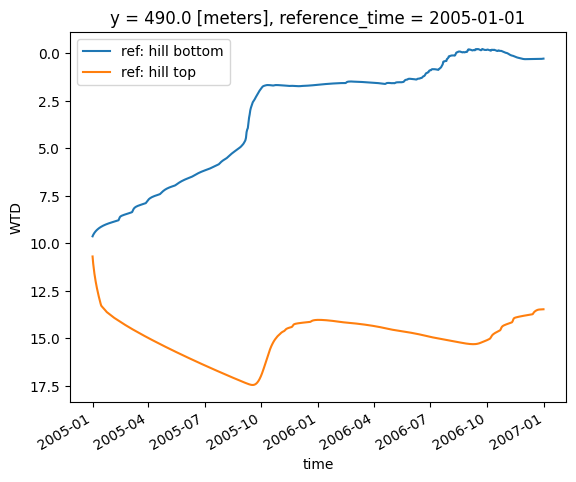

In [22]:
from matplotlib import pyplot as plt
ds1.WTD.isel(y=0).plot(label='ref: hill bottom')
ds1.WTD.isel(y=49).plot(label='ref: hill top')
plt.gca().legend()
plt.gca().invert_yaxis()

### 3.2. Runoff  <a class="anchor" id="t3_2"></a>

#### 3.2.1. Computed from the surface pressure (from CLM)  <a class="anchor" id="t3_2_1"></a>

Exemple of data accessor: https://parflow.readthedocs.io/en/latest/python/tutorials/data_accessor.html

In [31]:
data=hill.data_accessor

In [32]:
from parflow.tools import hydrology as pfhydro

**Does not work yet for 2D: **

In [40]:
manning = hill.Mannings.Geom.domain.Value

def calculate_overland_flow(da,slopex,slopey,mannings,dx,dy,mask):
    q = np.zeros(da.data.shape)
    for i in range(len(da.time)):
        #q[i,:] = pfhydro.calculate_overland_flow_grid(da.data[i,:][np.newaxis,:,np.newaxis],
        #                                              slopex=slopex,slopey=slopey,mannings=manning,
        #                                              dx=data.dx,dy=data.dy,mask=mask)
        q[i,:] = pfhydro.calculate_overland_flow(da.data[i,:][np.newaxis,:,np.newaxis],
                                                      slopex=slopex,slopey=slopey,mannings=manning,
                                                      dx=data.dx,dy=data.dy,
                                                        flow_method='OverlandFlow',mask=mask)        
    return (("time","y"),q)

dc1 = dc1.assign(Q=lambda x: calculate_overland_flow(x.htop,slopex=x.slopex,
                                                     slopey=x.slopey,mannings=manning,
                                                     dx=data.dx,dy=data.dy,mask=x.mask))


IndexError: too many indices

Solution to compute runoff at single outlet from pressure (**only works for OverlandFlow**)

In [69]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [70]:
manning = hill.Mannings.Geom.domain.Value
dc1 = dc1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.htop.data[:,0],
                                                         x.slopex.data[0,0],
                                                         x.slopey.data[0,0],
                                                         10,10,manning)))
dc1.Q.attrs['units']='m3/CLMtimestep'


/tmp/ipykernel_12459/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


#### 3.2.2. Read from the cumulative overlandsum file (from PF)  <a class="anchor" id="t3_2_2"></a>
this file is written at PF output time steps (often daily), and any flow between these steps is cumulated so that this files records all the outflow over time across the domain boundary. **Only works for OverlandFLow**

In [71]:
files = glob.glob(os.path.join(wdir,'*overlandsum.*.pfb'))
overlandsum = read_pfb_sequence(files)
np.shape(overlandsum)
ds1 = ds1.assign(Q = (('time','y'),overlandsum[:,0,:,0]))
ds1.Q.attrs['units']='m3/PFtimestep'

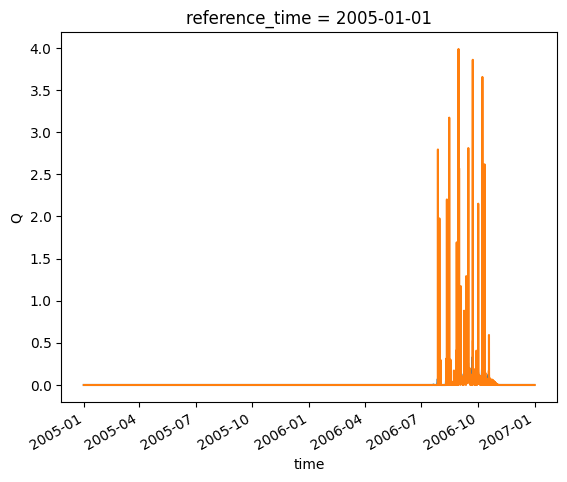

In [59]:
(ds1.Q.isel(y=0)/24).plot()
dc1.Q.plot()


### 3.3. Storage <a class="anchor" id="t3_3"></a>


In [72]:
## lectures de variables auxiliaires: 
ds1 = ds1.assign(poro=(("z","y","x"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,:]))
ds1 = ds1.assign(specstor=(("z","y","x"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,:]))

Get a header

In [80]:
with ParflowBinaryReader(glob.glob(wdir+'*.press.00000.pfb')[0]) as s: h = s.header
print(h)

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 50, 'nz': 24, 'dx': 10.0, 'dy': 10.0, 'dz': 1.0, 'n_subgrids': 2, 'p': 1, 'q': 2, 'r': 1}


In [82]:
ds1.z

<xarray.DataArray 'z' (z: 24)>
array([-5.000e-03, -1.500e-02, -2.500e-02, -3.500e-02, -8.600e-02, -1.780e-01,
       -2.700e-01, -3.620e-01, -4.540e-01, -5.800e-01, -7.400e-01, -9.000e-01,
       -1.060e+00, -1.220e+00, -1.420e+00, -1.660e+00, -1.900e+00, -2.140e+00,
       -2.380e+00, -4.650e+00, -8.950e+00, -1.325e+01, -1.755e+01, -2.185e+01])
Coordinates:
  * z               (z) float64 -0.005 -0.015 -0.025 ... -13.25 -17.55 -21.85
    reference_time  datetime64[ns] 2005-01-01
Attributes:
    units:    meters

In [107]:
ds1 = ds1.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.vdz*x.poro*x.satur + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.poro*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
ds1 = ds1.assign(storage=lambda x: x.storage_cbyc.sum(dim=('x','z')))
ds1.storage.attrs['units']='m3'
ds1.storage_cbyc.attrs['units']='m3'